In [1]:
df353.meiyu <-  read.csv('D:/Molly/Data/precp/df353_Meiyu.csv', header = T, sep = ',')
station353 <- read.csv('D:/Molly/Data/station/station_353_adj.csv', header = T, sep = ',')

In [2]:
library(sp)
library(rgeos)
library(magrittr)
library(leaflet)
library(zoo)

rgeos version: 0.5-1, (SVN revision 614)
 GEOS runtime version: 3.6.1-CAPI-1.10.1 
 Linking to sp version: 1.3-1 
 Polygon checking: TRUE 



Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




## Arbitrary Function `FindNearest`

In [3]:
# n: number of the nearest stations
# df_precp: data frame that contains precp
# ChosenID: the chosen ID 

FindNearest = function(df_precp, n, ChosenID){
  position <- station353[, 4:5]                                    # Longitude and Latitude 
  coordinates(position) <- ~ Longitude + Latitude
  d <- gDistance(position, byid = T)                               # Distance 
  d.min <- apply(d, 1, function(x) order(x, decreasing = F)[2:(n+1)]) # The 9 closest stations
  colnames(d.min) <- station353$StationID                          # Column names are station names
  
  d.min.st_name <- apply(d.min, 2, function(y) station353$StationName[y]) 
  d.min.st_id <- apply(d.min, 2, function(y) station353$StationID[y])
  
  st.chosen.id <- ChosenID                                         # The ID of the chosen station
  st.chosen.ind <- which(st.chosen.id == colnames(d.min)) 
  d.min.st_id[, st.chosen.ind]                                     # IDs of 9 closest stations
  
  Nearest <- rbind(st.chosen.id, as.matrix(d.min.st_id[, st.chosen.ind]))
  Nearest.adj <- apply(Nearest, 1, function(x){if(grepl('C',x) == T) x=x else paste0('X',x)})
  Nearest.ind <- match(Nearest.adj, names(df_precp))               # index of precp in df353.meiyu
  
  st.name <- as.character(station353[station353$StationID == st.chosen.id,2])  
  st.name9 <- d.min.st_name[, which(st.chosen.id == colnames(d.min.st_name))]
  st.names <- c(st.name, st.name9)
  return.list <- list('Nearest.adj' = Nearest.adj, 'Nearest.ind' = Nearest.ind, 'st.names' = st.names)
  
  return(return.list)
}
f <- FindNearest(df_precp = df353.meiyu, n = 9, ChosenID = '466910')

## AVBL.PCA (5mm = 80% quantile for df.meiyu)

In [4]:
N <- length(df353.meiyu$Time)/24;N # 549 days
AVBL.PCA <- matrix(NA, N, 1)       
for(i in 1:N){
  d1.ind <- i*24
  d0.ind <- (i*24)-23
  df <- df353.meiyu[d0.ind:d1.ind, f$Nearest.ind]
  df[is.na(df)] <- 0 
  rownames(df) <- paste0('t', seq(1,24,1))
  
  ind.rows <- which(apply(as.matrix(df, ncol=10), 1, max) >= 5)
  if(length(ind.rows) >= 2){
    AVBL.PCA[i] <- 1
    next
  }else{
    AVBL.PCA[i] <- 0
  }
}

[1] 549

In [5]:
M <- cbind(unique(substr(df353.meiyu$Time,1,10)), AVBL.PCA)
colnames(M) <- c('Date','AVBL.PCA')
head(M,10)

Date,AVBL.PCA
2010/05/01,0
2010/05/02,0
2010/05/03,0
2010/05/04,0
2010/05/05,0
2010/05/06,1
2010/05/07,1
2010/05/08,0
2010/05/09,0
2010/05/10,1


In [43]:
AbSt <- matrix(NA, length(which(AVBL.PCA==1)), 1)      # Abnormal station 
DSt <- matrix(NA, length(which(AVBL.PCA==1)), 1)
CumProp.St <- list()                                   # cumsum props

AbTime <- matrix(NA, length(which(AVBL.PCA==1)), 1)    # Abnormal hour 
DTime <- matrix(NA, length(which(AVBL.PCA==1)), 1)
CumProp.Time <- list() 

for(i in 1:length(which(AVBL.PCA == 1))){
  # Data preprocess
  d1.ind <- (which(AVBL.PCA == 1)[i])*24
  d0.ind <- d1.ind-23
  df <- df353.meiyu[d0.ind:d1.ind, f$Nearest.ind]
  df[is.na(df)] <- 0 
  rownames(df) <- paste0('t', seq(1,24,1))
  ind.rows <- which(apply(as.matrix(df, ncol=10), 1, max) >= 5)
  
  # Dataframe  
  df.space <- df[ind.rows,]
  
  # Find the columns that have the same precp
  res <- lapply(df.space, function(x) duplicated(x))
  res2 <- lapply(1:10, function(y) length(which(res[[y]] == TRUE)) != 0)
  df.space[1, which(res2 == TRUE)] <- df.space[1, which(res2 == TRUE)] + 0.01
  df.time <- data.frame(t(df.space))
  
  # Conduct PCA
  pca.space <- prcomp(df.space, center = T, scale. = T)
  pca.time <- prcomp(df.time, center = T, scale. = T)
  pc1.space <- pca.space$x[,1]; pc2.space <- pca.space$x[,2]
  pc1.time <- pca.time$x[,1]; pc2.time <- pca.time$x[,2]
  
  # Percentage of explained variance
  vars.space <- (pca.space$sdev)^2;          vars.time <- (pca.time$sdev)^2
  props.space <- vars.space/sum(vars.space); props.time <- vars.time/sum(vars.time)
  cusum.props.space <- cumsum(props.space);  cusum.props.time <- cumsum(props.time)
  
  # Twist
  CumProp.Time[[i]] <- round(cusum.props.space, 3)
  CumProp.St[[i]] <- round(cusum.props.time, 3)
  
  # Compute the largest distance
  distance.space <- sqrt((pc1.space)^2 + (pc2.space)^2)
  distance.time <- sqrt((pc1.time)^2 + (pc2.time)^2)
  
  ind.abtime <- which.max(distance.space)
  AbTime[i] <- names(distance.space)[ind.abtime]
  DTime[i] <- distance.space[ind.abtime]
  
  ind.abst <- which.max(distance.time)
  AbSt[i] <- f$st.names[ind.abst]
  DSt[i] <- distance.time[ind.abst]
}
M.Time <- cbind(AbTime, DTime)
M.Space <- cbind(AbSt, DSt)

In [44]:
table(AbSt)

AbSt
  三和   三芝   天母   平等   石牌 竹子湖   淡水   鞍部   關渡 
    55     27      6     20      2      6      6      8      6 

In [45]:
table(AbTime)

AbTime
 t1 t10 t11 t12 t13 t14 t15 t16 t17 t18 t19  t2 t20 t21 t22 t23 t24  t3  t4  t5 
  9   9   3   5   5   6  10  18  13   7   5   1   1   5   3   5   1   6   6   4 
 t6  t7  t8  t9 
  5   3   4   2 

## 三和、三芝及平等站的PC1, PC2距原點的距離

In [56]:
summary(as.numeric(M.Space[AbSt == '三和', 2]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.826   2.939   4.022   4.252   5.480   8.248 

In [58]:
summary(as.numeric(M.Space[AbSt == '三芝', 2]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.871   2.704   3.336   3.496   3.813   6.588 

In [59]:
summary(as.numeric(M.Space[AbSt == '平等', 2]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.249   2.603   3.115   3.303   3.681   6.030 

In [55]:
M2 <- cbind(AbSt, AbTime, round(DSt, 4), round(DTime, 4))
M3 <- M2[AbSt == '三芝', ] # The abnormal station
M4 <- cbind(Dates_st_8, M3)
colnames(M4) <- c('Date','AbSt','AbTime','DSt', 'DTime')
M4

Date,AbSt,AbTime,DSt,DTime
2010/05/07,三芝,t10,3.2438,3.382
2010/05/23,三芝,t17,4.3505,3.615
2010/05/27,三芝,t14,1.8709,2.2361
2010/06/10,三芝,t17,3.192,4.764
2010/06/13,三芝,t17,3.3357,4.5966
2010/06/26,三芝,t18,2.7988,2.8792
2011/05/13,三芝,t1,3.0797,3.0864
2011/05/15,三芝,t15,3.2523,2.6559
2012/05/02,三芝,t19,3.4357,3.4632
2012/05/16,三芝,t16,2.4748,2.2361


## 雨量圖
我們將M4表格中，距離大於4的天數畫出來

In [136]:
M4$DSt <- as.numeric(as.character(M4$DSt))
M4$DTime <- as.numeric(as.character(M4$DTime))
M4[M4$DSt >= 4, ]

,Date,AbSt,AbTime,DSt,DTime
,<fct>,<fct>,<fct>,<dbl>,<dbl>
2,2010/05/23,三芝,t17,4.3505,3.6150
15,2013/05/11,三芝,t4,6.4025,5.8058
16,2013/06/10,三芝,t24,4.5029,3.3789
18,2014/05/21,三芝,t21,5.1674,6.9735
24,2016/06/14,三芝,t12,4.4183,3.9181
25,2017/06/02,三芝,t11,6.5882,7.1670


## 2010/5/23 三芝站
DSt約為 4.3505

,鞍部,大屯山,竹子湖,天母,石牌,平等,關渡,三芝,淡水,三和
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
t13,11.5,7.0,9.5,8.0,8.5,6.5,11.0,11.5,11.0,11.5
t16,3.0,1.5,1.0,0.5,0.5,1.0,0.5,13.0,1.5,7.0
t17,10.5,7.5,7.5,7.5,10.5,7.5,12.0,16.5,11.5,15.0
t18,5.5,4.5,7.0,8.0,7.0,8.5,5.5,5.0,5.5,6.0
t20,2.5,1.5,0.5,2.0,2.0,2.5,1.0,6.5,4.0,3.0
t21,3.5,3.0,6.0,6.0,5.0,6.0,4.0,1.0,1.5,3.5


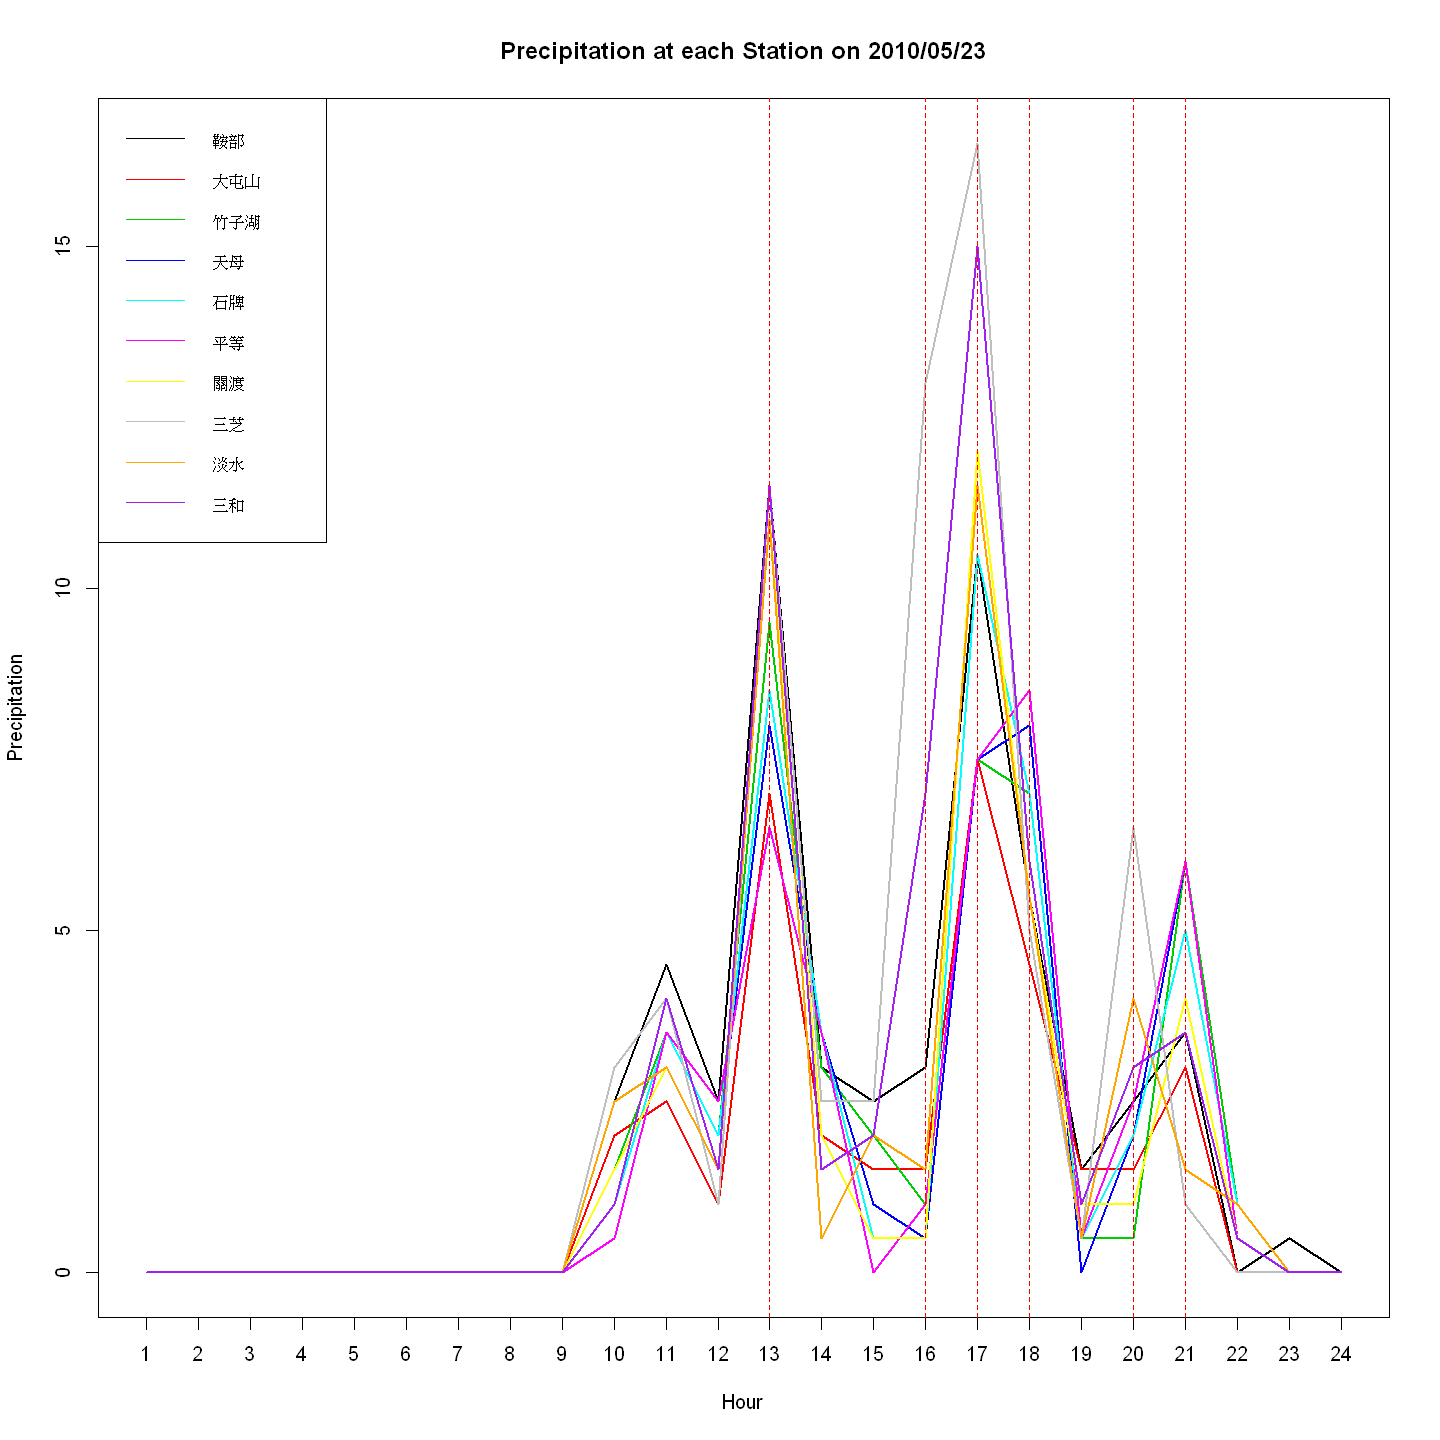

In [86]:
options(repr.plot.width=12, repr.plot.height=12)
d0.ind <- which(df353.meiyu$Time %in% '2010/05/23 01')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, f$Nearest.ind]
df[is.na(df)] <- 0 
rownames(df) <- paste0('t', seq(1,24,1))
colnames(df) <- f$st.names
df.space <- df

ind.rows <- which(apply(as.matrix(df, ncol=10), 1, max) >= 5)
df[ind.rows,]


# Overplotted
plot.zoo(df.space, 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = 'Precipitation at each Station on 2010/05/23',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:24, labels = seq(1,24,1))
legend('topleft', legend=f$st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.8)
abline(v = ind.rows, lty=2, col=2)


上圖的紅色垂直虛線為該日中拿來進行PCA的小時，第13、16、17、18、20及21小時

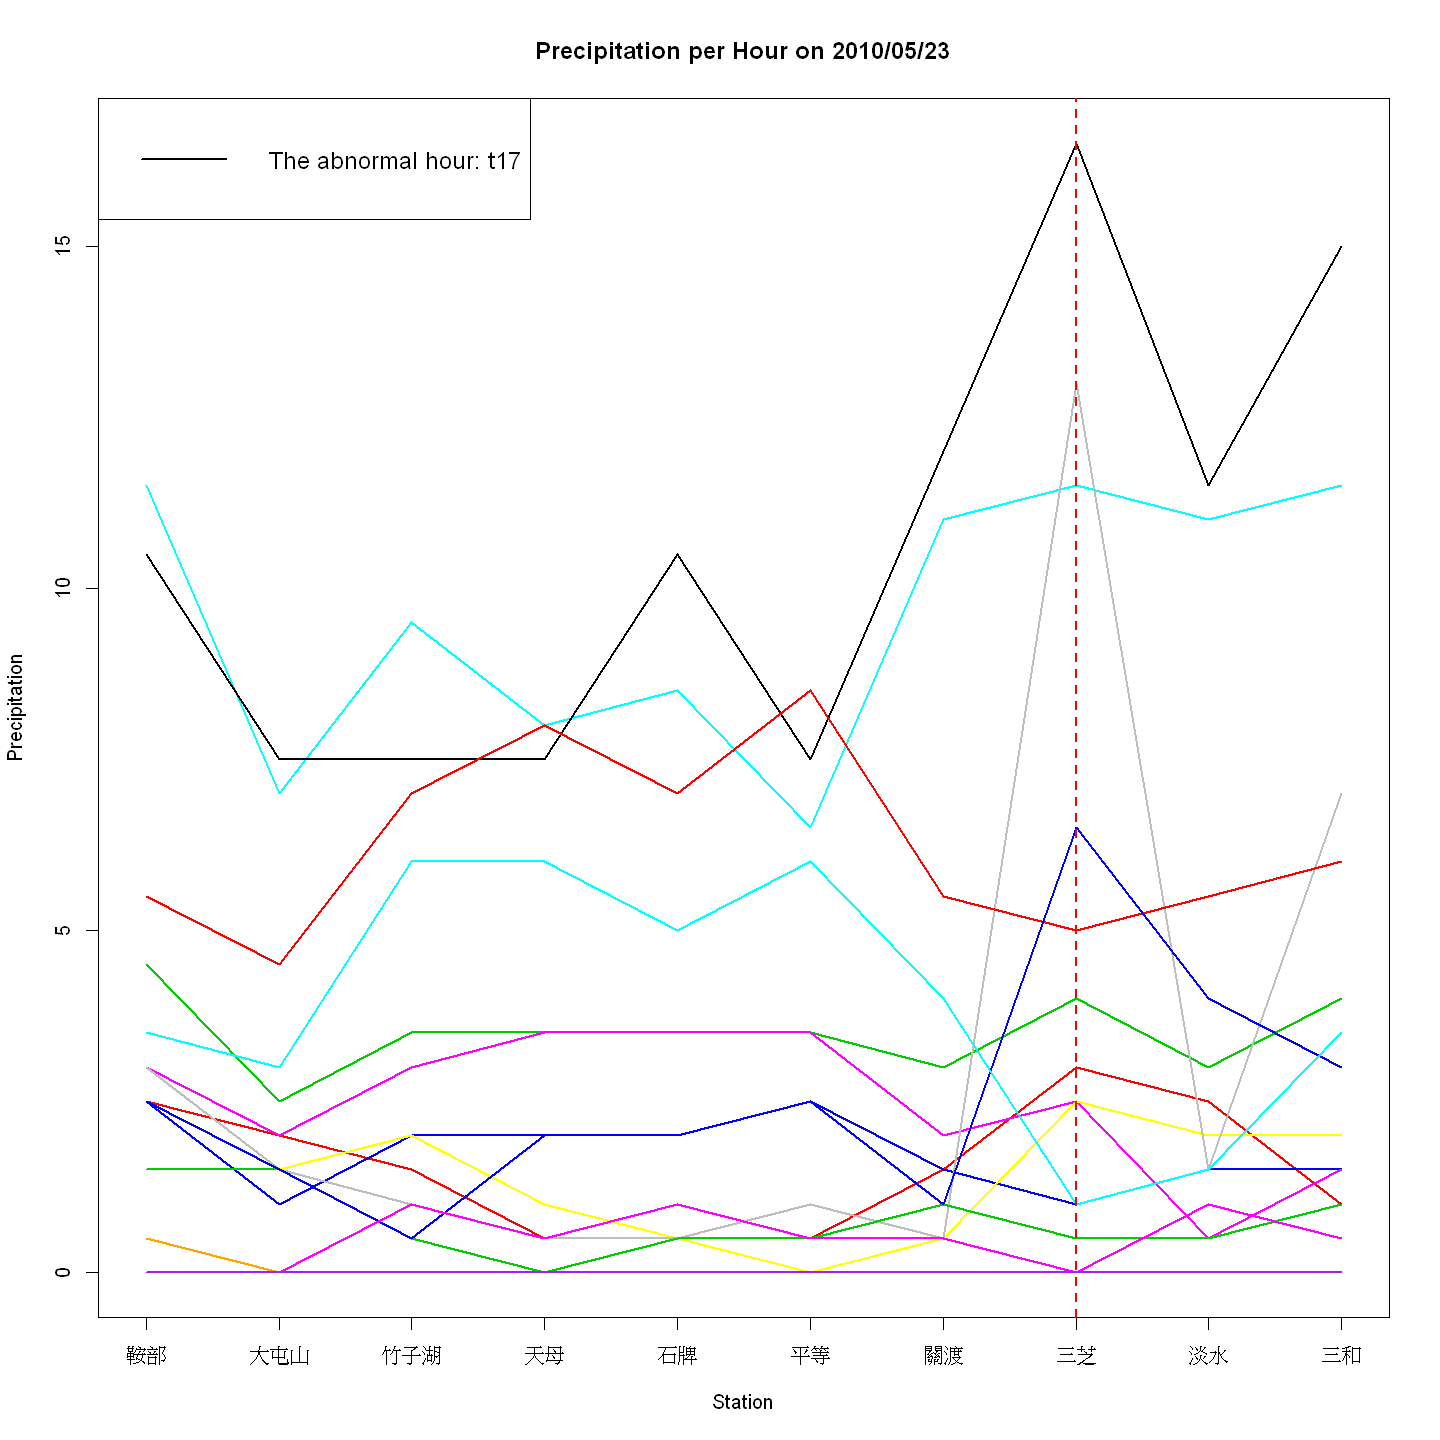

In [72]:
df.time <- t(df)
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = 'Precipitation per Hour on 2010/05/23',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = f$st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topleft', legend=c('The abnormal hour: t17'), lty=1, col=17, cex=1.2, lwd=2, text.width=1.8)

## 2013/05/11 三芝站
DSt約為 6.4025

,鞍部,大屯山,竹子湖,天母,石牌,平等,關渡,三芝,淡水,三和
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
t2,31.5,24.0,20.5,13.0,13.0,3.0,25.0,12.0,20.5,17.0
t3,31.0,23.5,17.0,9.5,9.0,10.5,14.5,36.5,24.0,24.5
t4,52.0,35.5,31.5,22.5,22.5,19.5,31.0,39.0,35.0,40.0
t5,41.0,33.5,28.5,25.0,24.5,24.5,33.0,22.5,45.0,39.5
t6,26.5,23.0,22.5,20.0,21.5,20.0,26.0,12.0,22.5,23.5
t7,19.5,18.5,15.0,15.0,16.5,14.5,24.0,21.0,18.5,26.5
t8,13.5,16.0,21.0,21.0,22.0,20.5,18.0,5.5,11.0,17.5
t9,14.0,13.5,17.0,15.0,14.5,22.0,14.5,1.5,8.0,15.5
t10,6.0,5.0,7.0,7.5,7.5,7.5,5.5,0.0,3.0,5.5


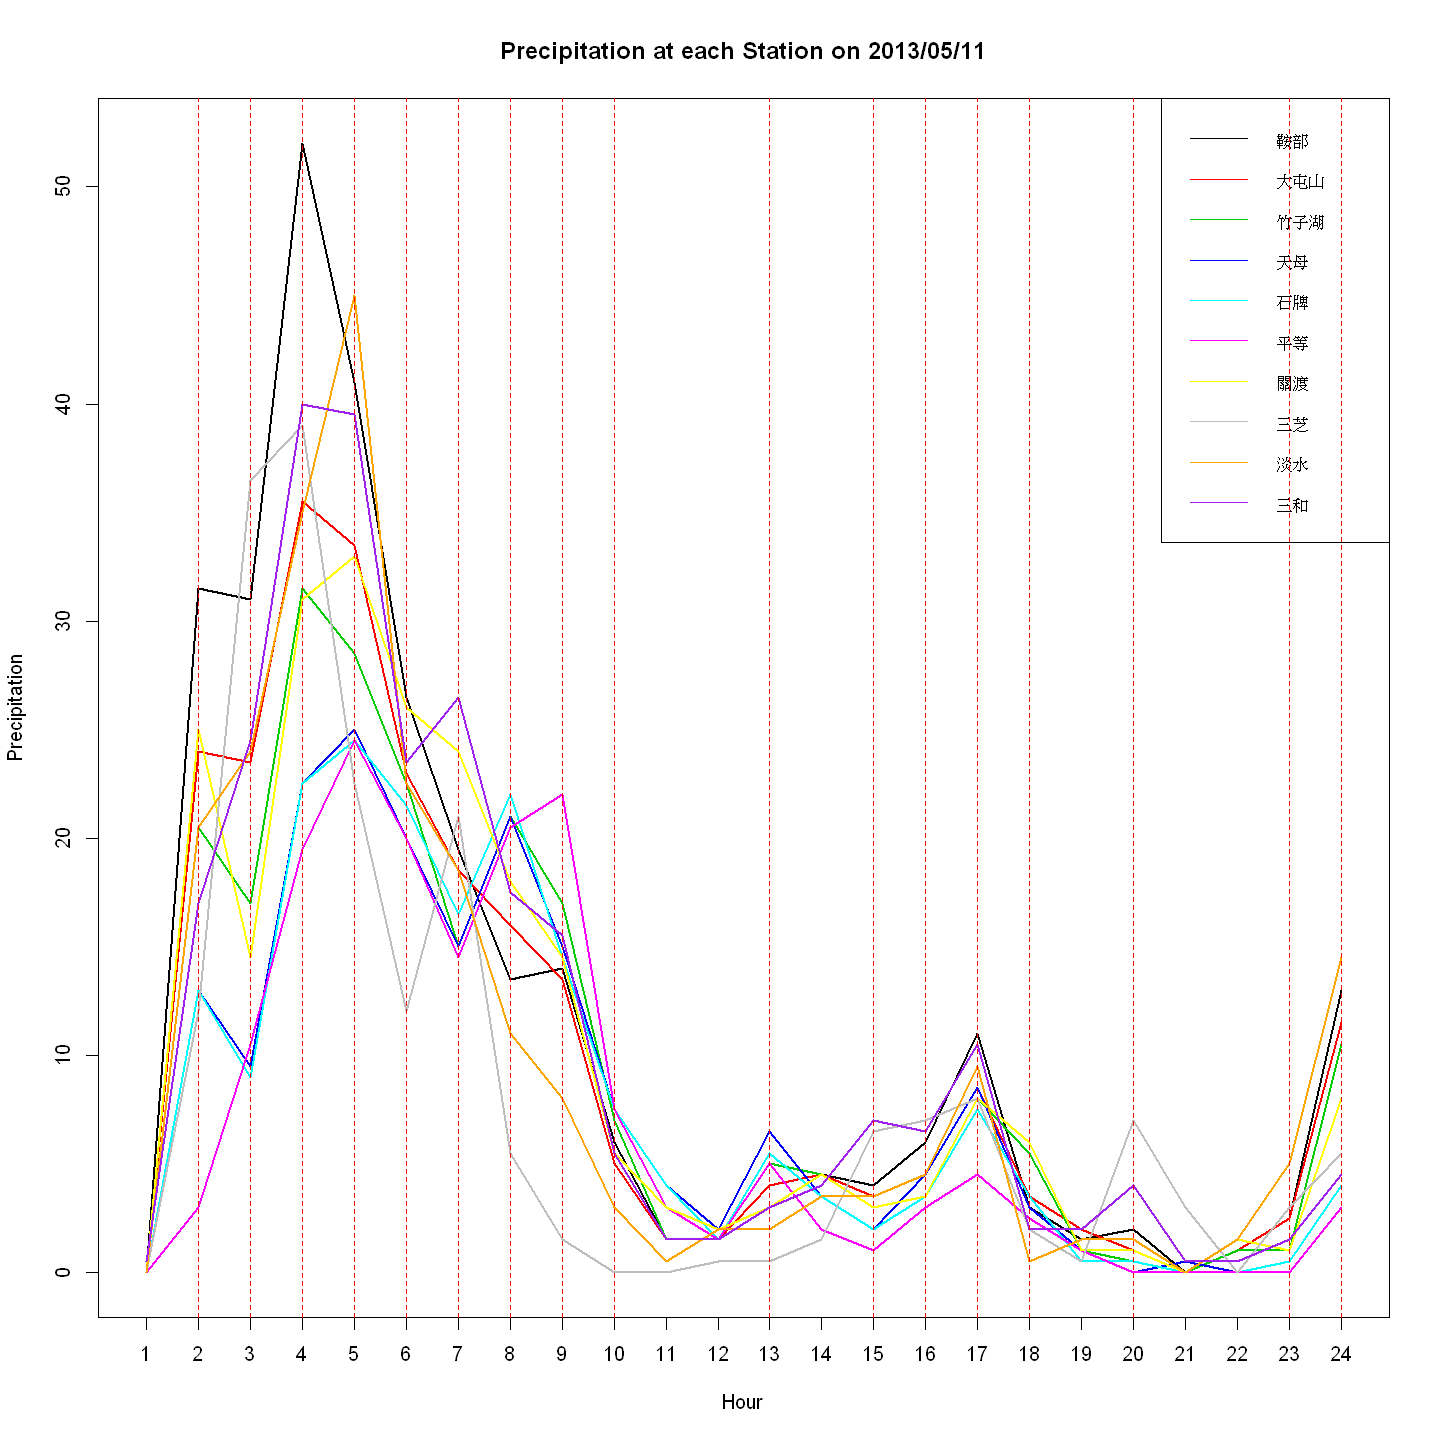

In [110]:
options(repr.plot.width=12, repr.plot.height=12)
d0.ind <- which(df353.meiyu$Time %in% '2013/05/11 01')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, f$Nearest.ind]
df[is.na(df)] <- 0 
rownames(df) <- paste0('t', seq(1,24,1))
colnames(df) <- f$st.names
df.space <- df
ind.rows <- which(apply(as.matrix(df, ncol=10), 1, max) >= 5)
df[ind.rows,]
# Overplotted
plot.zoo(df.space, 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = 'Precipitation at each Station on 2013/05/11',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:24, labels = seq(1,24,1))
legend('topright', legend=f$st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.8)
abline(v = ind.rows, lty=2, col=2)

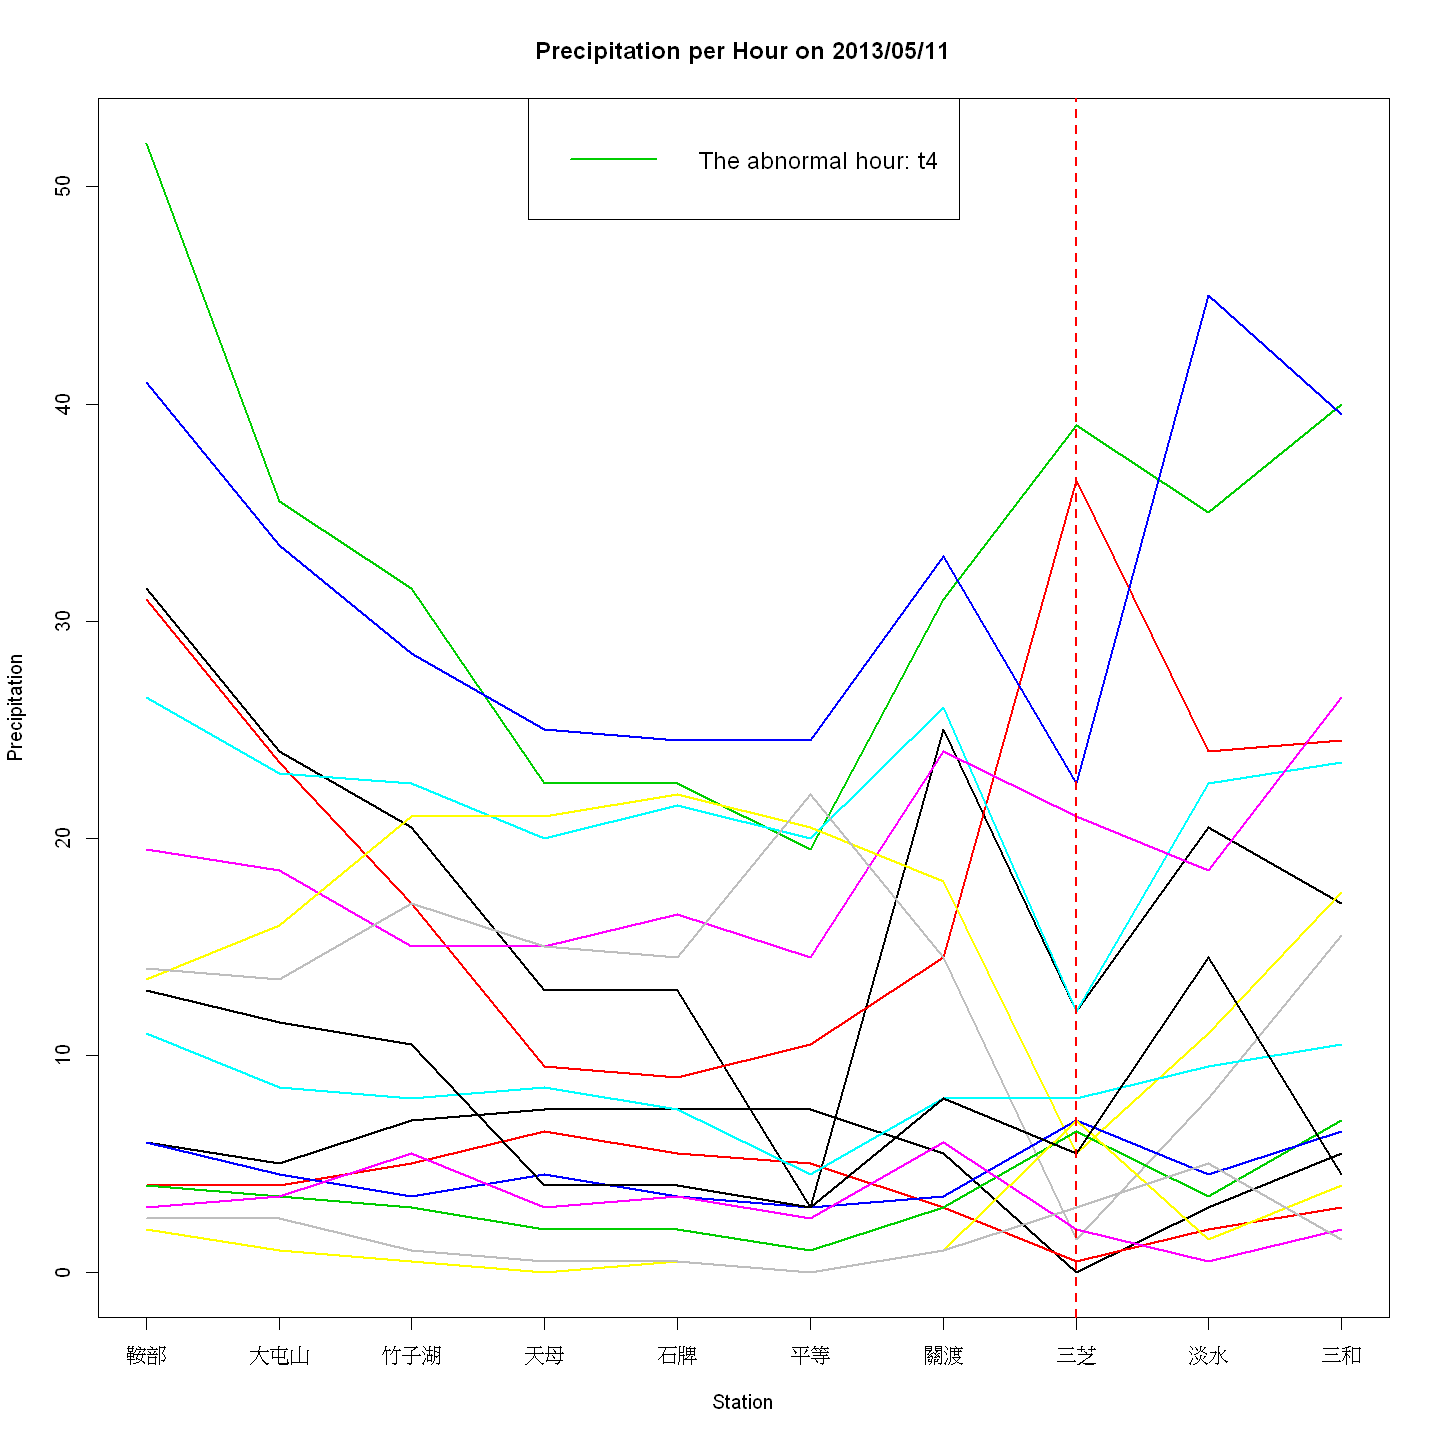

In [113]:
df.time <- t(df[ind.rows,])
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = 'Precipitation per Hour on 2013/05/11',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = f$st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('top', legend=c('The abnormal hour: t4'), lty=1, col=3, cex=1.2, lwd=2, text.width=1.8)

## 2013/06/10 三芝站
DSt約為 4.5029

,鞍部,大屯山,竹子湖,天母,石牌,平等,關渡,三芝,淡水,三和
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
t3,0.0,0.0,0.0,5,2.5,10.5,0.0,0.5,0.5,3.0
t6,0.0,0.0,0.0,0,0.5,0.0,0.0,8.5,0.5,0.0
t7,2.5,1.5,0.5,0,0.0,0.0,2.5,8.5,8.0,2.5
t8,0.5,0.5,0.0,0,0.0,0.0,0.0,10.0,0.0,1.0
t24,2.0,5.5,9.0,2,1.0,1.5,3.0,0.0,0.5,5.5


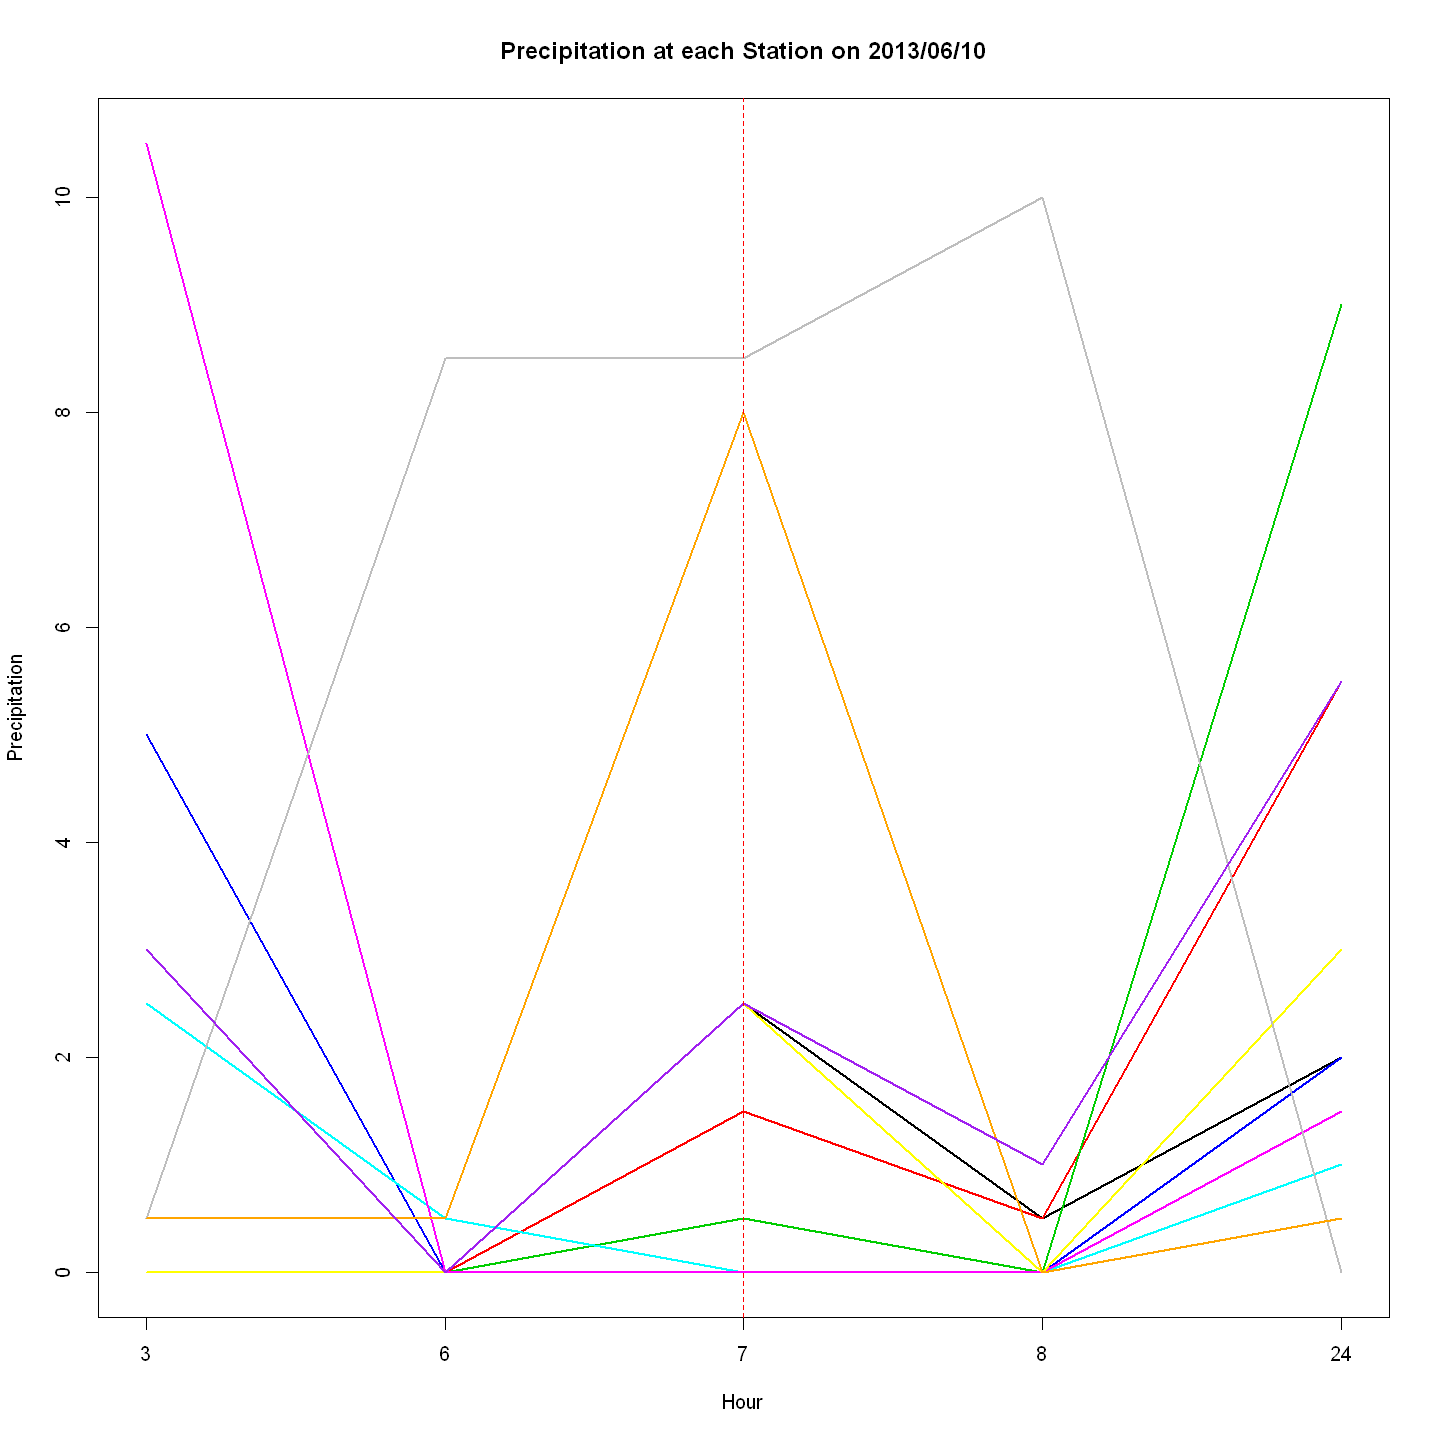

In [103]:
options(repr.plot.width=12, repr.plot.height=12)
d0.ind <- which(df353.meiyu$Time %in% '2013/06/10 01')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, f$Nearest.ind]
df[is.na(df)] <- 0 
rownames(df) <- paste0('t', seq(1,24,1))
colnames(df) <- f$st.names
df.space <- df
ind.rows <- which(apply(as.matrix(df, ncol=10), 1, max) >= 5)
df[ind.rows,]
# Overplotted
plot.zoo(df[ind.rows,], 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = 'Precipitation at each Station on 2013/06/10',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:5, labels = c(3,6,7,8,24))
# legend('top', legend=f$st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.8)
abline(v = ind.rows, lty=2, col=2)

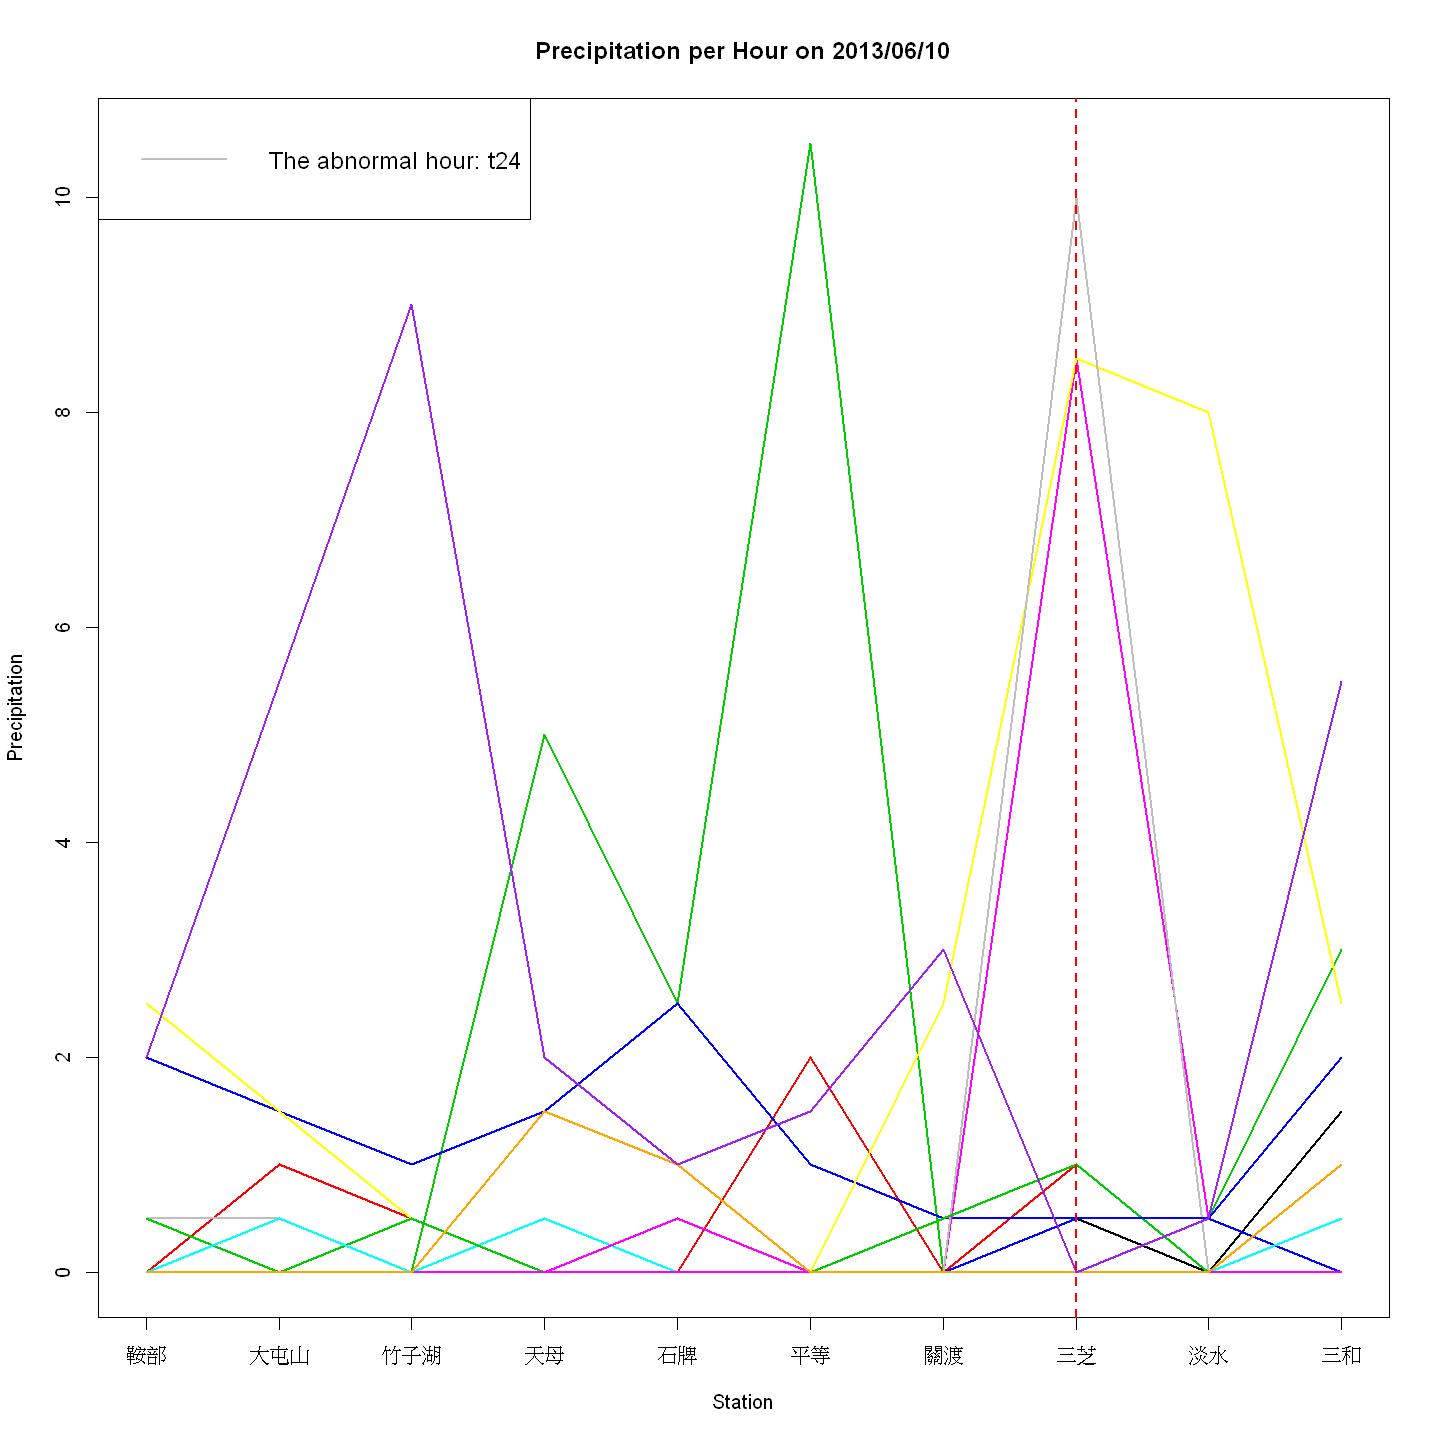

In [81]:
df.time <- t(df)
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = 'Precipitation per Hour on 2013/06/10',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = f$st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topleft', legend=c('The abnormal hour: t24'), lty=1, col=24, cex=1.2, lwd=2, text.width=1.8)

## 2014/05/21	三芝	t21	5.1674

,鞍部,大屯山,竹子湖,天母,石牌,平等,關渡,三芝,淡水,三和
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
t1,10.0,10.0,9.5,9.5,13.0,7.0,17.0,0.5,9.5,4.0
t2,1.0,2.0,2.0,8.0,9.0,4.5,10.0,0.5,2.5,0.5
t3,5.5,6.5,9.0,9.5,8.0,5.0,7.0,0.0,7.5,0.0
t4,8.5,11.0,14.0,1.0,1.5,0.0,4.5,0.0,13.0,0.0
t7,9.0,6.5,5.5,2.0,2.5,1.0,4.0,0.5,3.5,4.5
t8,3.0,2.0,2.0,1.0,1.0,0.5,3.5,0.5,5.0,5.0
t9,7.0,9.5,10.5,6.5,8.0,5.0,9.5,1.0,9.5,3.5
t11,4.5,5.5,3.0,3.0,2.5,2.5,2.0,1.0,3.0,2.5
t12,5.5,4.0,3.5,1.0,0.5,1.0,0.5,6.0,2.5,10.5


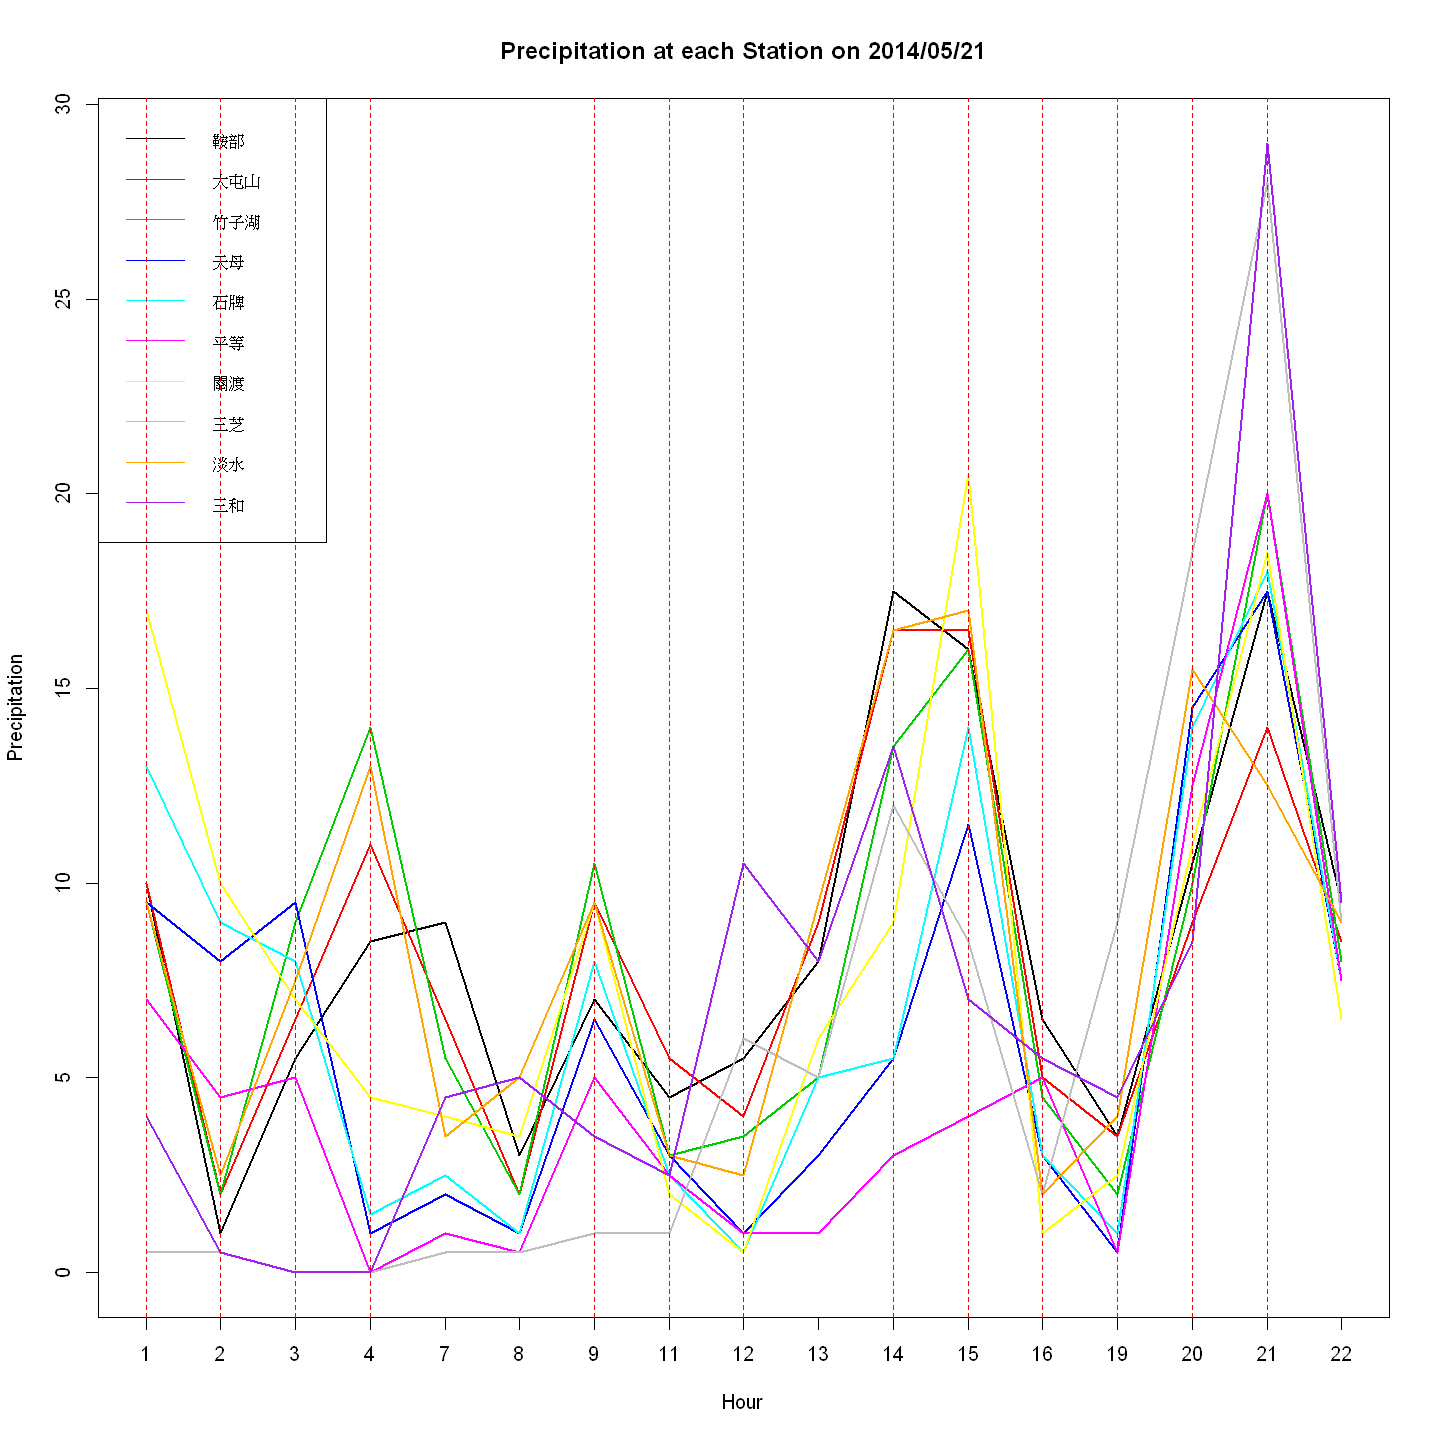

In [100]:
d0.ind <- which(df353.meiyu$Time %in% '2014/05/21 01')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, f$Nearest.ind]
df[is.na(df)] <- 0 
rownames(df) <- paste0('t', seq(1,24,1))
colnames(df) <- f$st.names
df.space <- df
ind.rows <- which(apply(as.matrix(df, ncol=10), 1, max) >= 5)
df[ind.rows,]
# Overplotted
plot.zoo(df[ind.rows,], 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = 'Precipitation at each Station on 2014/05/21',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:17, labels = c(1:4,7:9,11:16,19:22))
legend('topleft', legend=f$st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.8)
abline(v = ind.rows, lty=2, col=2)

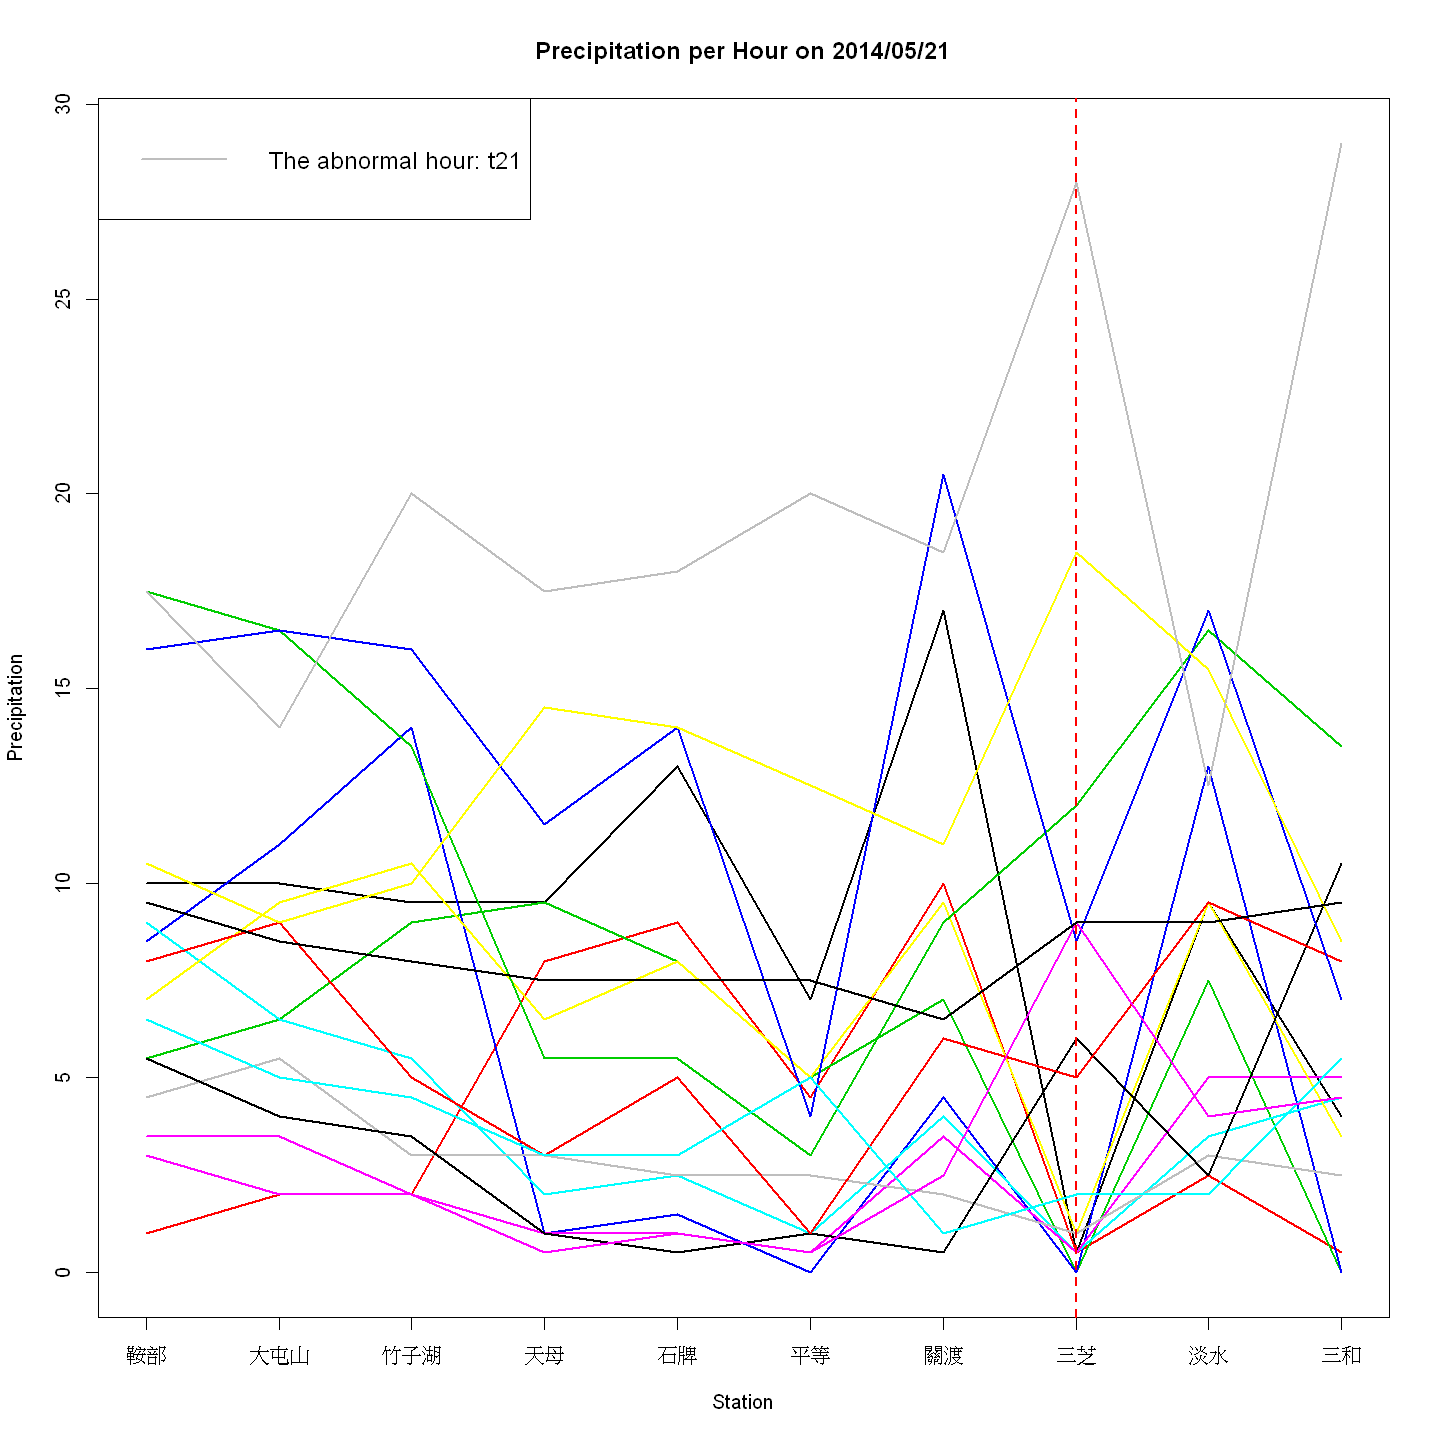

In [91]:
df.time <- t(df[ind.rows,])
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = 'Precipitation per Hour on 2014/05/21',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = f$st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topleft', legend=c('The abnormal hour: t21'), lty=1, col=16, cex=1.2, lwd=2, text.width=1.8)

## 2016/06/14	三芝	t12	4.4183	

,鞍部,大屯山,竹子湖,天母,石牌,平等,關渡,三芝,淡水,三和
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
t10,5.0,3.0,2.9,2.5,3.0,2.0,5.0,6.0,5.5,3.5
t11,14.0,9.5,10.8,8.5,9.0,7.5,13.5,8.5,18.0,6.5
t12,16.0,14.0,10.2,9.0,9.0,8.5,16.5,20.5,17.5,7.0
t13,10.5,8.5,13.8,8.5,9.5,10.0,9.0,6.0,7.5,6.5
t14,6.0,4.5,5.3,4.0,4.0,5.5,2.5,3.0,4.0,2.5
t15,9.0,6.5,7.2,5.5,6.0,5.5,7.0,18.0,7.0,6.5
t16,6.5,4.0,4.9,7.0,6.5,6.5,6.0,11.0,5.5,7.5


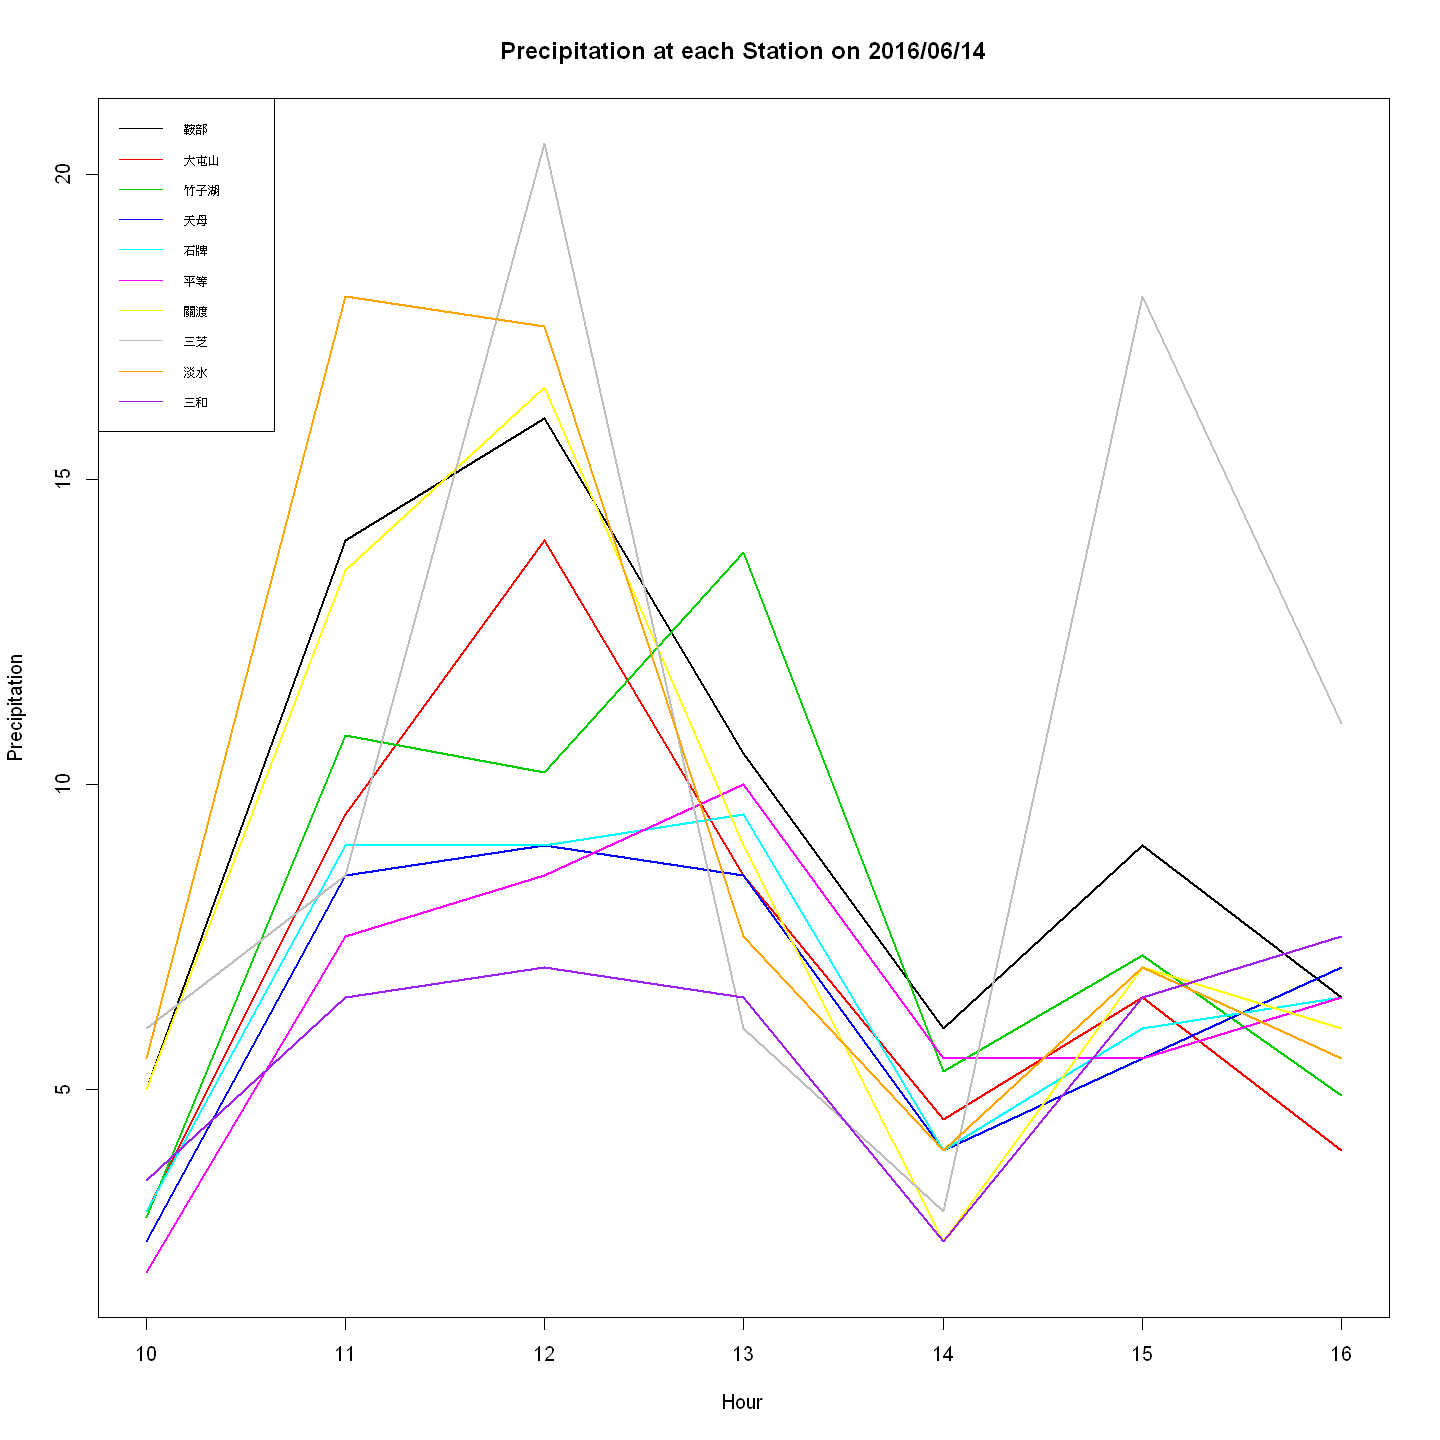

In [106]:
d0.ind <- which(df353.meiyu$Time %in% '2016/06/14 01')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, f$Nearest.ind]
df[is.na(df)] <- 0 
rownames(df) <- paste0('t', seq(1,24,1))
colnames(df) <- f$st.names
df.space <- df
ind.rows <- which(apply(as.matrix(df, ncol=10), 1, max) >= 5)
df[ind.rows,]
# Overplotted
plot.zoo(df[ind.rows,], 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = 'Precipitation at each Station on 2016/06/14',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:7, labels = seq(10,16,1))
legend('topleft', legend=f$st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.6)
abline(v = ind.rows, lty=2, col=2)

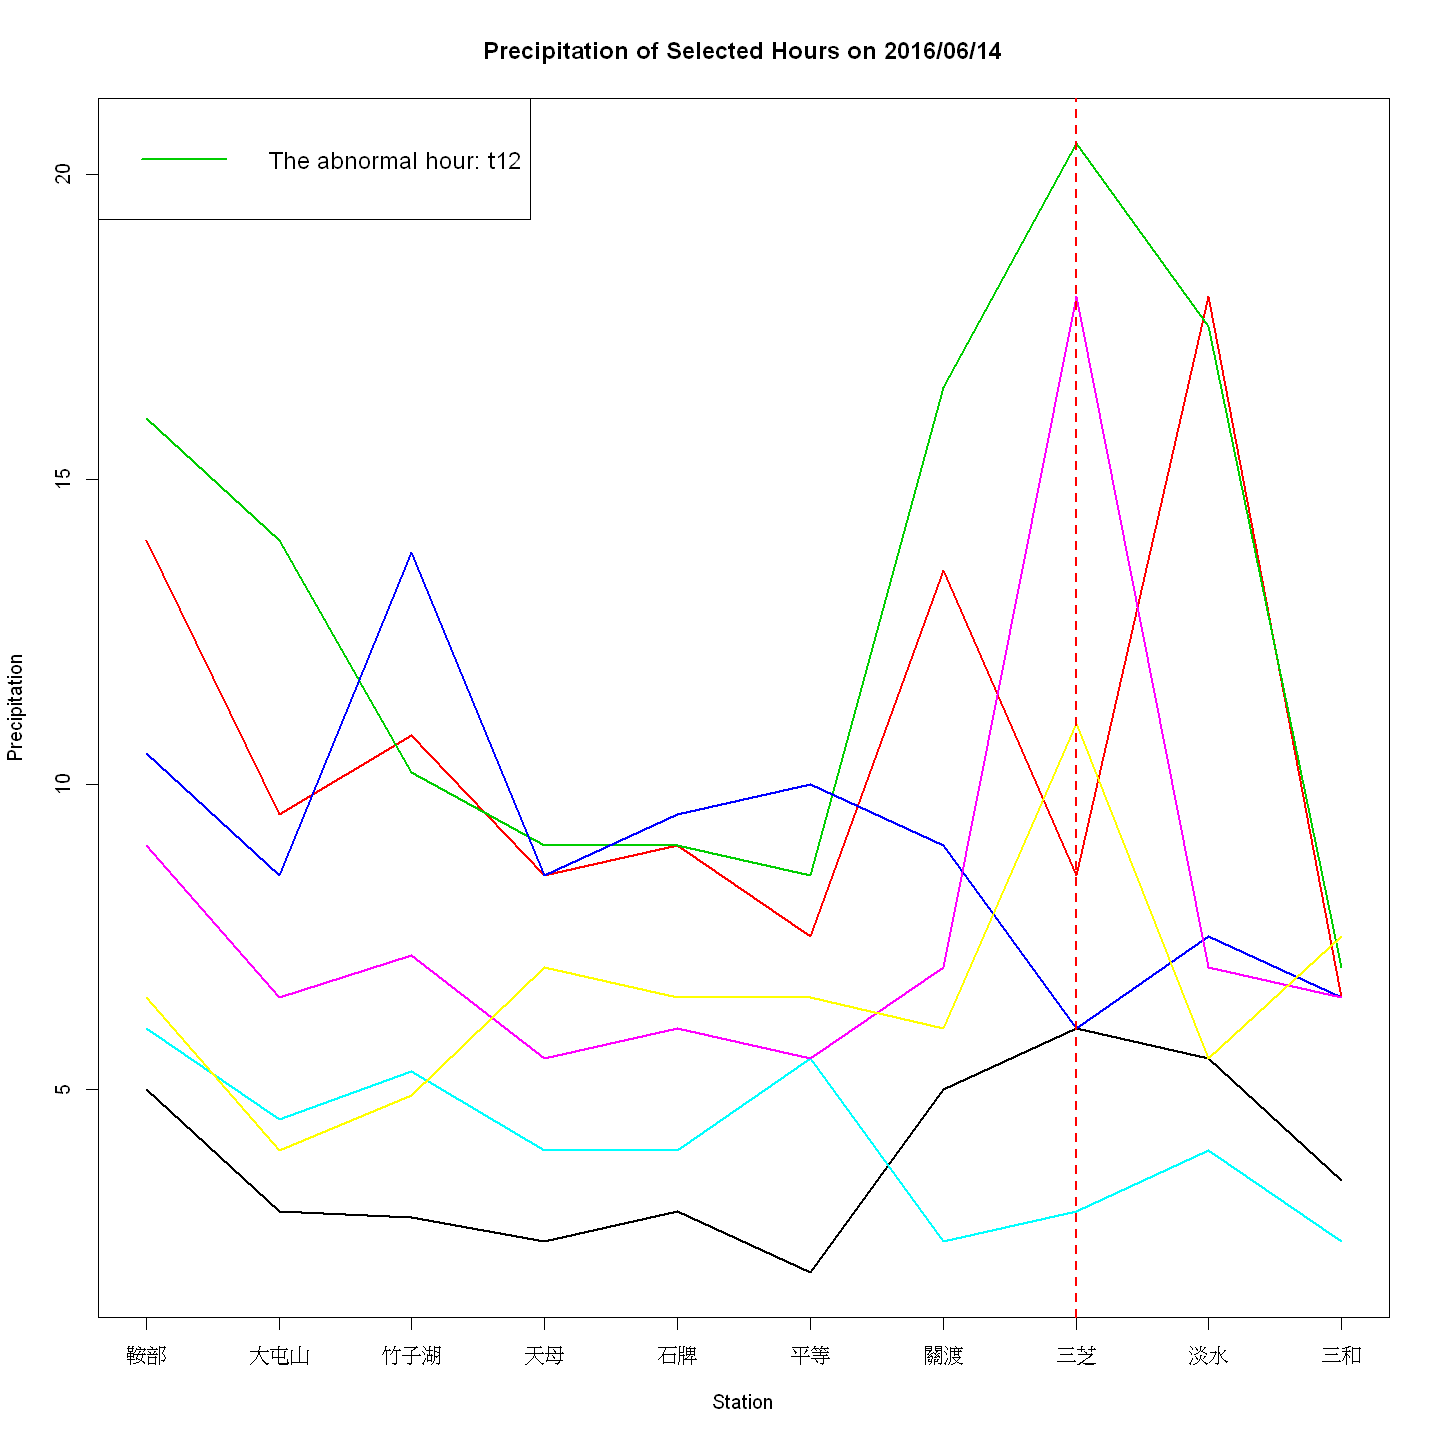

In [108]:
df.time <- t(df[ind.rows,])
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = 'Precipitation of Selected Hours on 2016/06/14',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = f$st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topleft', legend=c('The abnormal hour: t12'), lty=1, col=3, cex=1.2, lwd=2, text.width=1.8)

## 2017/06/02	三芝	t11	6.5882

,鞍部,大屯山,竹子湖,天母,石牌,平等,關渡,三芝,淡水,三和
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
t2,5.5,5.5,2.7,1.0,1.0,4.0,3.0,5.0,5.0,11.0
t3,8.5,5.0,3.6,0.5,0.5,0.5,0.5,56.0,2.0,54.0
t4,38.0,29.5,11.4,9.5,9.0,19.5,18.0,88.0,46.0,70.5
t5,42.5,33.0,31.8,33.0,21.0,44.5,21.0,74.5,42.0,65.5
t6,27.5,18.5,21.6,3.5,2.5,6.0,4.0,73.0,11.5,69.0
t7,53.0,55.5,36.4,22.5,20.5,37.0,30.5,69.0,67.0,65.0
t8,4.5,1.5,20.3,0.0,0.5,1.0,0.5,62.0,0.0,37.0
t9,0.0,0.5,0.0,0.0,0.0,0.0,0.0,21.0,0.0,7.0
t10,26.5,23.0,20.7,1.5,2.0,6.0,16.5,112.0,42.5,63.0


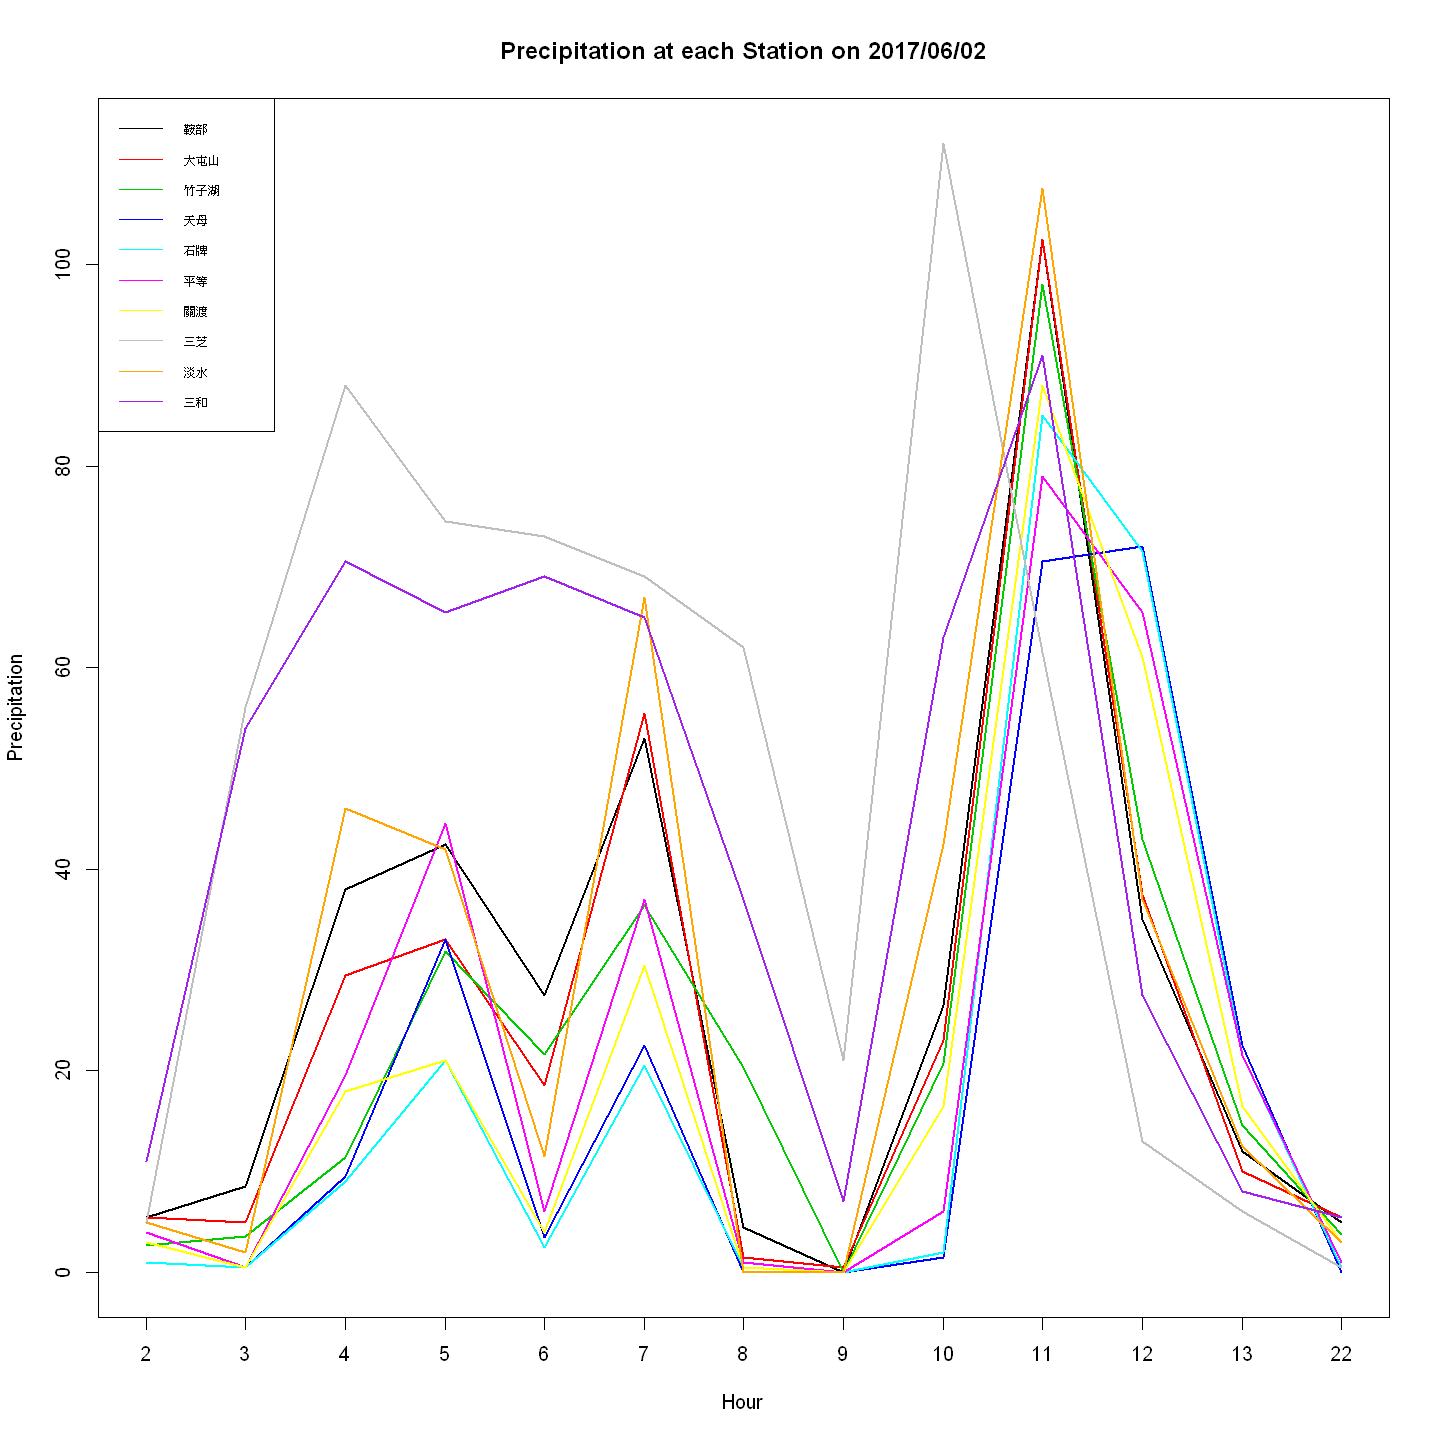

In [123]:
d0.ind <- which(df353.meiyu$Time %in% '2017/06/02 00')
d1.ind <- d0.ind+24-1
df <- df353.meiyu[d0.ind:d1.ind, f$Nearest.ind]
df[is.na(df)] <- 0 
rownames(df) <- paste0('t', seq(1,24,1))
colnames(df) <- f$st.names
df.space <- df
ind.rows <- which(apply(as.matrix(df, ncol=10), 1, max) >= 5)
df[ind.rows,]
# Overplotted
plot.zoo(df[ind.rows,], 
         plot.type = "single", 
         col = c(1:8,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Hour',
         main = 'Precipitation at each Station on 2017/06/02',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:13, labels = c(2:13,22))
legend('topleft', legend=f$st.names, lty=1, col=c(1:8,'Orange','Purple'), cex = 0.6)
# abline(v = ind.rows, lty=2, col=2)

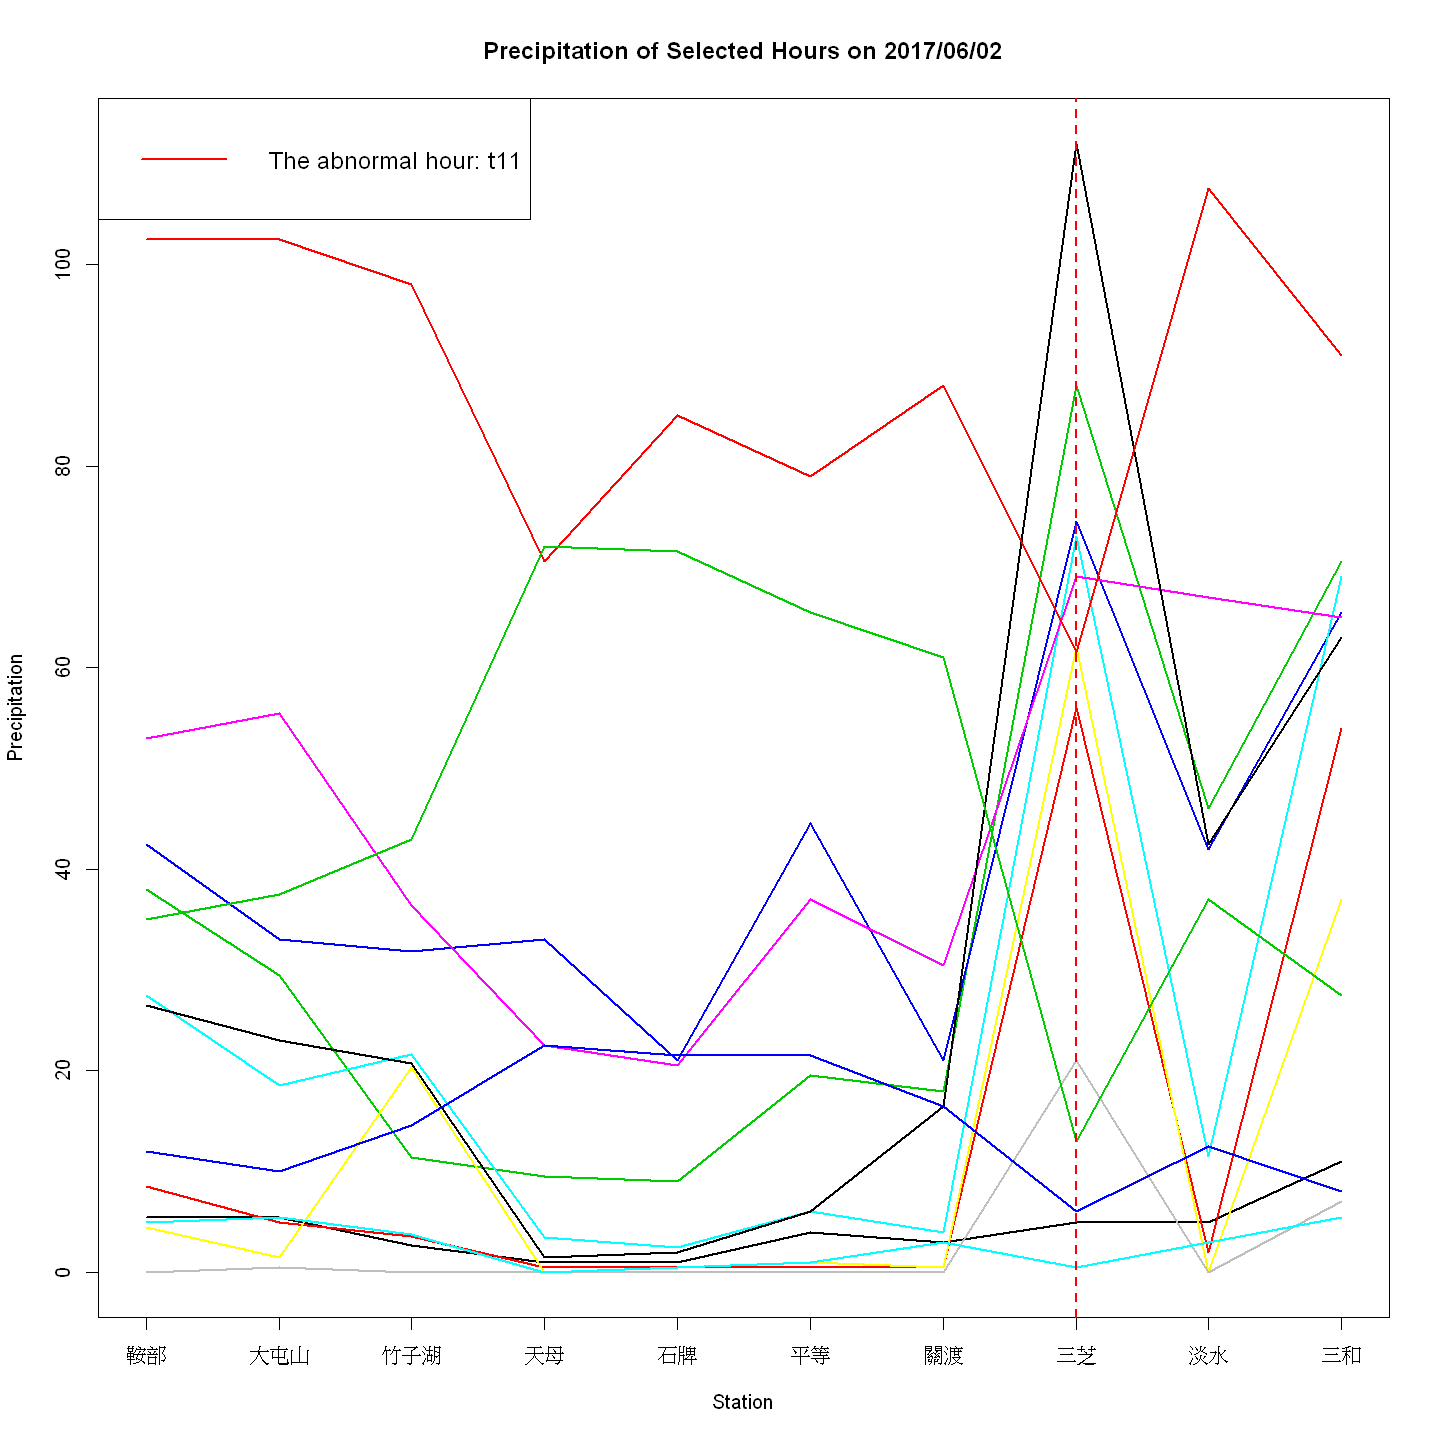

In [124]:
df.time <- t(df[ind.rows,])
plot.zoo(df.time, 
         plot.type = "single", 
         col = c(1:22,'Orange','Purple'),
         ylab = 'Precipitation',
         xlab = 'Station',
         main = 'Precipitation of Selected Hours on 2017/06/02',
         lwd = 2,
         xaxt = 'n')
axis(1, at = 1:10, labels = f$st.names)
abline(v = 8, col = 2, lwd = 2, lty = 2)
legend('topleft', legend=c('The abnormal hour: t11'), lty=1, col=10, cex=1.2, lwd=2, text.width=1.8)